# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import pytz
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest import (BacktestEngine, InstrumentDef,
                             Performance, signal, processing, rebase)
from vivace.backtest.engine import long_only_returns
from vivace.enums import Strategy, Weighting, PnLType

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

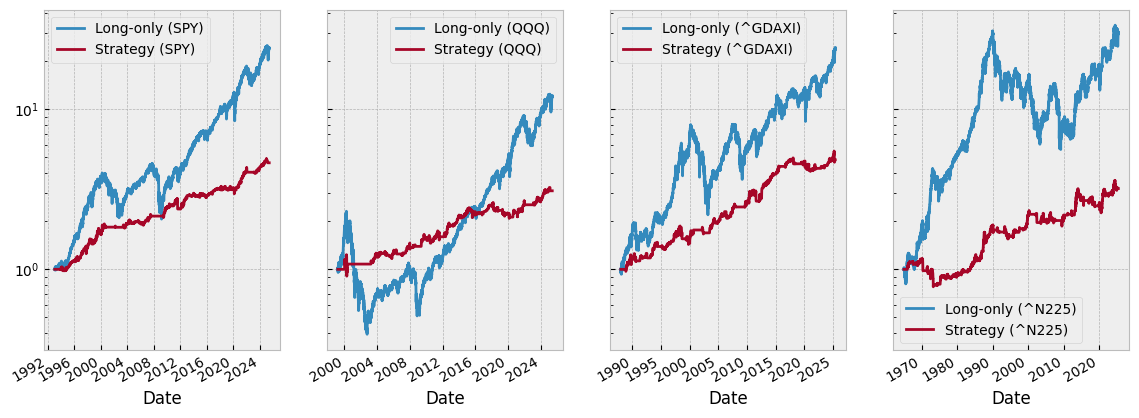

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098695,0.047449,0.095276,0.043145,0.084865,0.041969,0.057629,0.019725
Annualised vol,0.187421,0.071706,0.272526,0.098489,0.218212,0.082221,0.202711,0.075835
Sharpe ratio,0.526593,0.661711,0.349605,0.438068,0.388910,0.510448,0.284289,0.260106
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.233963,0.818712,0.335098
Calmar ratio,0.178829,0.337099,0.114841,0.162210,0.116757,0.179384,0.070389,0.058863
Skewness,-0.006680,-0.799603,0.234128,1.514875,-0.126398,-1.810426,-0.204062,-3.206080
Kurtosis,11.744005,39.878616,7.050732,70.210438,6.588387,65.983803,9.353679,113.033752
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.128878,-0.243342,-0.127345


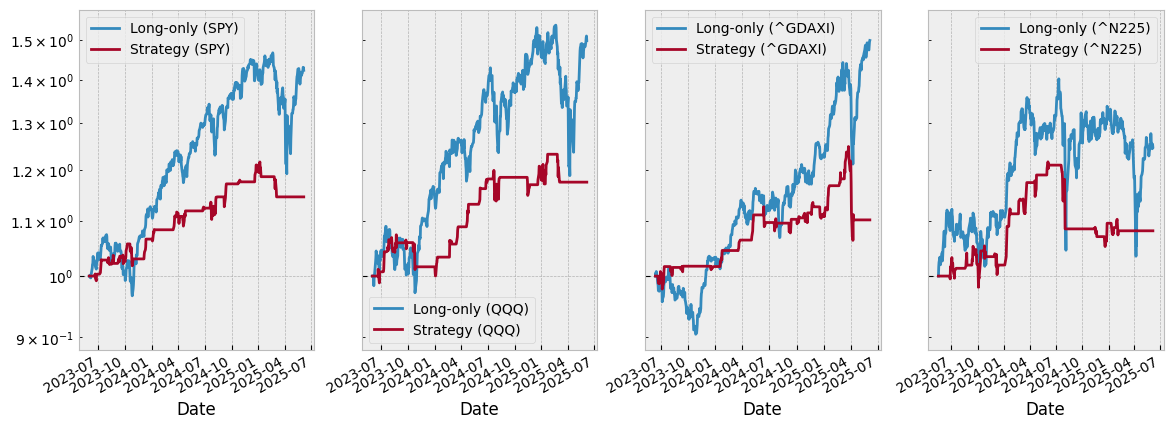

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

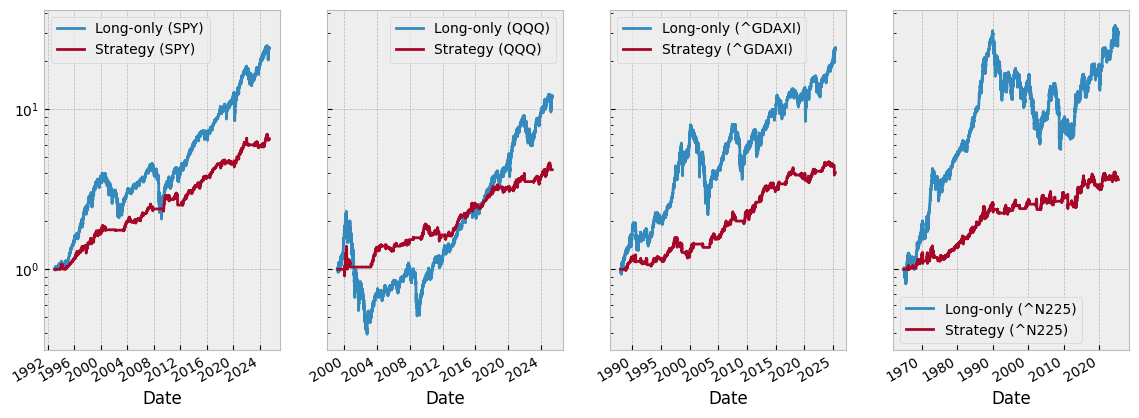

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098695,0.058241,0.095276,0.054732,0.084865,0.037046,0.057629,0.021924
Annualised vol,0.187421,0.081741,0.272526,0.113187,0.218212,0.088688,0.202711,0.087103
Sharpe ratio,0.526593,0.712512,0.349605,0.483551,0.388910,0.417711,0.284289,0.251708
Max drawdown,0.551894,0.163106,0.829639,0.282276,0.726848,0.256756,0.818712,0.219014
Calmar ratio,0.178829,0.357077,0.114841,0.193894,0.116757,0.144284,0.070389,0.100106
Skewness,-0.006680,-0.583986,0.234128,0.677856,-0.126398,-0.300741,-0.204062,-2.430965
Kurtosis,11.744005,27.293838,7.050732,45.371070,6.588387,16.908853,9.353679,79.596972
Worst return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.086648,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.081137,-0.246190,-0.246190,-0.216097,-0.087830,-0.243342,-0.127345


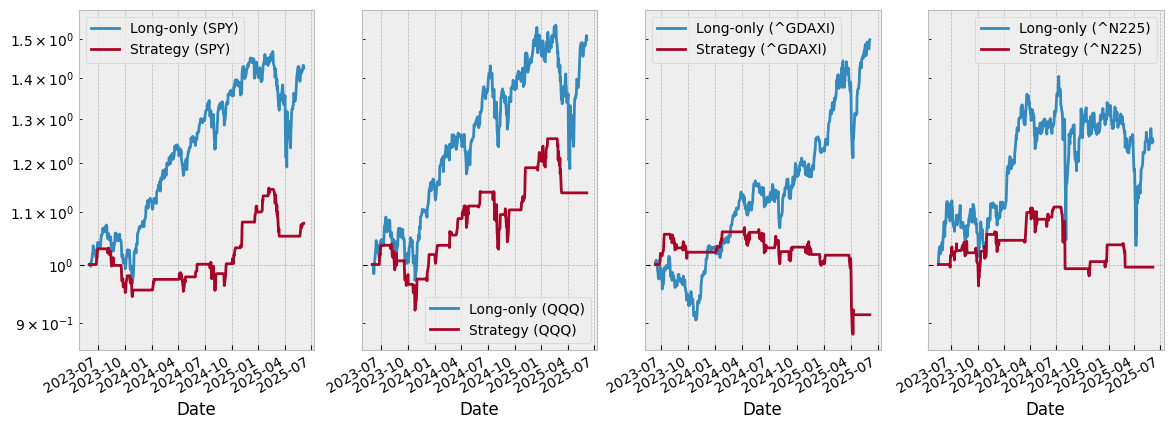

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

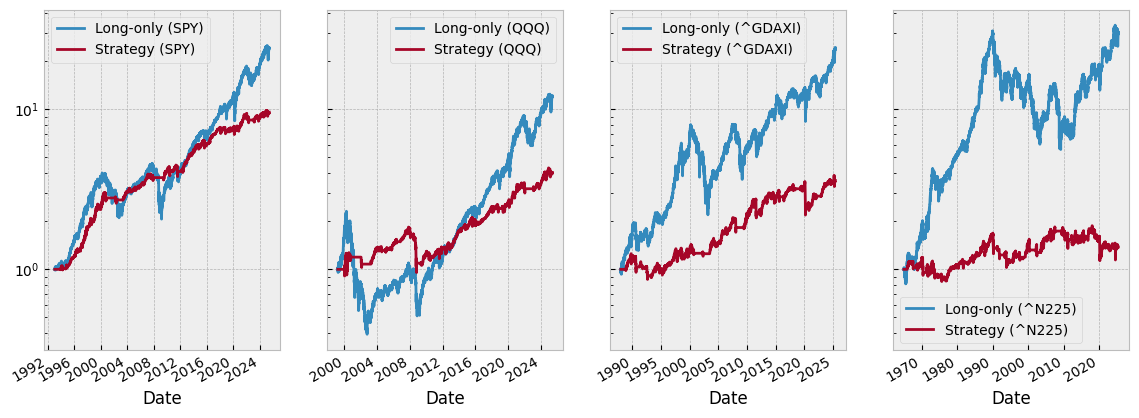

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098695,0.070011,0.095276,0.053294,0.084865,0.034076,0.057629,0.005470
Annualised vol,0.187421,0.097878,0.272526,0.141797,0.218212,0.116931,0.202711,0.108205
Sharpe ratio,0.526593,0.715293,0.349605,0.375848,0.388910,0.291422,0.284289,0.050554
Max drawdown,0.551894,0.153225,0.829639,0.480136,0.726848,0.382193,0.818712,0.395910
Calmar ratio,0.178829,0.456918,0.114841,0.110998,0.116757,0.089160,0.070389,0.013817
Skewness,-0.006680,-0.311203,0.234128,0.606116,-0.126398,-1.182185,-0.204062,-1.694410
Kurtosis,11.744005,17.358918,7.050732,32.061263,6.588387,36.486731,9.353679,51.671701
Worst return,-0.109424,-0.072473,-0.119788,-0.089556,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.089556,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.246190,-0.216097,-0.200123,-0.243342,-0.159939


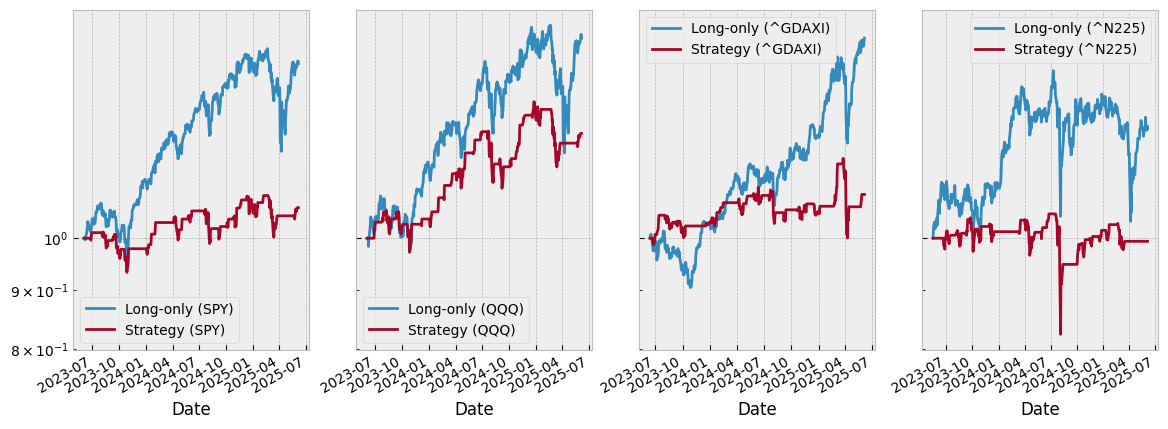

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

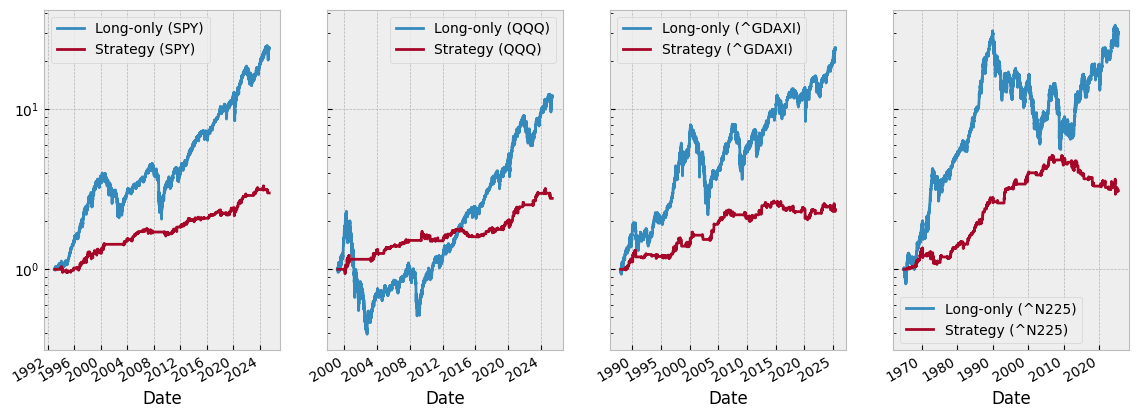

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy (SPY),Long-only (QQQ),Strategy (QQQ),Long-only (^GDAXI),Strategy (^GDAXI),Long-only (^N225),Strategy (^N225)
CAGR,0.098695,0.034017,0.095276,0.038984,0.084865,0.022936,0.057629,0.019203
Annualised vol,0.187421,0.061409,0.272526,0.081068,0.218212,0.067324,0.202711,0.063140
Sharpe ratio,0.526593,0.553944,0.349605,0.480883,0.388910,0.340677,0.284289,0.304140
Max drawdown,0.551894,0.111611,0.829639,0.134186,0.726848,0.238856,0.818712,0.428543
Calmar ratio,0.178829,0.304784,0.114841,0.290524,0.116757,0.096024,0.070389,0.044811
Skewness,-0.006680,-0.798771,0.234128,0.403360,-0.126398,-0.439719,-0.204062,-2.553727
Kurtosis,11.744005,46.193351,7.050732,39.205035,6.588387,28.133445,9.353679,151.451446
Worst return,-0.109424,-0.072473,-0.119788,-0.057517,-0.131434,-0.049530,-0.149009,-0.123958
Worst 1d return,-0.109424,-0.072473,-0.119788,-0.057517,-0.131434,-0.049530,-0.149009,-0.123958
Worst 1w return,-0.197934,-0.111611,-0.246190,-0.106267,-0.216097,-0.124379,-0.243342,-0.127345


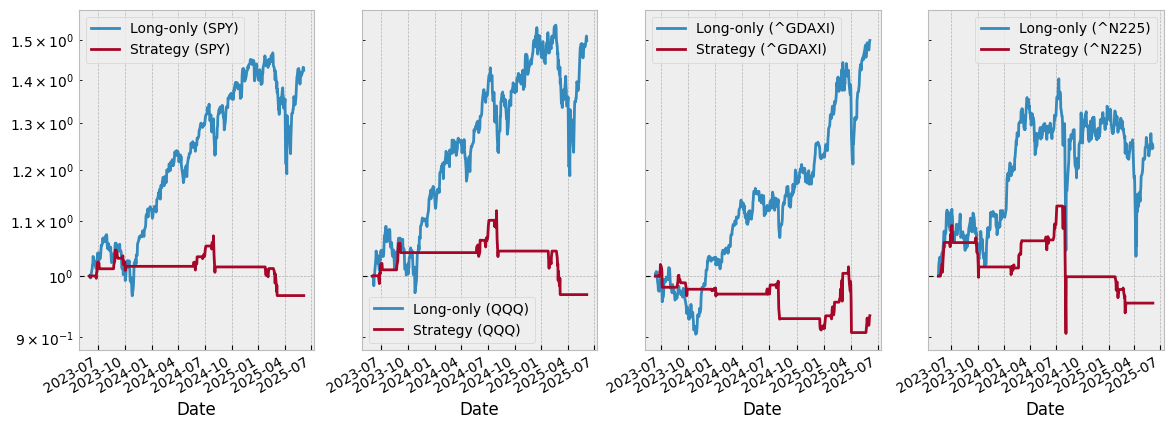

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.now(pytz.utc):%d-%b-%Y %H:%M}')

Updated: 06-Jun-2025 21:20
